In [352]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from datetime import datetime

In [353]:
df = pd.read_csv("../data/Ana_Health-Tabela_Modelo_Previsao_Churn.csv",skiprows=1)

# Criando dataframe com os dados com ocorrência única de won ou lost

In [354]:
colunas = ['id_person','state', 'city', 'postal_code', 'id_person_recommendation', 'Recebe Comunicados?', 'Interesses', 'Pontos de Atenção',
           'id_stage', 'id_org', 'status.1', 'activities_count', 'Qde Todos Atendimentos', 'Faltas Todos Atendimento', 'Datas Atendimento Médico',
           'Datas Acolhimento', 'Datas Psicoterapia','Qde Prescrições', 'Datas Prescrição', 'Qde Respostas WHOQOL']

df = df.drop(colunas, axis=1)

### Transformando a coluna de 'status' em apenas o último status

In [355]:
# def lastStatus(x):
#     if pd.isnull(x):
#         return 'none'
#     s = x.split(';')
#     return s[-1].strip()

# df['status'] = df['status'].apply(lastStatus)
def lastStatus(x):
    s = x.split(';')
    return s[-1].strip()

df['status'] = df['status'].dropna().apply(lastStatus)

In [356]:
df['status'].value_counts()

won     586
lost    492
Name: status, dtype: int64


Se o cliente tiver mais de um start of service é considerado o primeiro

In [357]:
def first_date(x):
    if pd.isnull(x):
        return x
    s = x.split(';')
    return s[0].strip()


df['start_of_service'] = df['start_of_service'].apply(first_date)



Se o cliente tiver com status won e lost_reason é para eliminar o lost_reason
Se estiver com status lost é considerado o último lost_reason

In [358]:
def lost_reason_lost(x,y):
    if pd.isnull(x) or pd.isnull(y):
        return None
    
    if x == 'won':
        return None
    
    s = y.split(';')
    return s[-1].strip()

In [359]:
df['lost_reason'] = df.apply(lambda row: lost_reason_lost(row['status'], row['lost_reason']), axis=1)
df['lost_reason'].value_counts()

[Assinatura] Desligamento                                                                   221
[Assinatura] Não quer seguir com a Ana                                                       64
[Assinatura] Empresa cancelou o benefício da Ana                                             55
[Assinatura] Precisou cortar custos                                                          28
[Assinatura] Cancelamento por inadimplência                                                  26
[Assinatura] Está sem tempo para conciliar os atendimentos                                   23
[Assinatura] Cancelamento após saída da psicoterapeuta do time da Ana                        11
[Assinatura] Não estava sentindo evolução na psicoterapia                                     7
[Assinatura] Final do Piloto                                                                  5
[Assinatura] Desengajou após sentir melhora das questões que a levaram para psicoterapia      5
[Assinatura] Recebeu um benefício simila

In [360]:
def devolve_media(x):
    if pd.isnull(x):
        return None
    x = x.replace(',','.')
    s = x.split(';')
    s = [float(i) for i in s]
    return np.mean(s)

In [361]:
colunas_whoqol = ['Físico', 'Psicológico', 'Social', 'Ambiental']
for coluna in colunas_whoqol:
    df[coluna] = df[coluna].apply(devolve_media)

In [362]:
df['Físico'].describe()

count    898.000000
mean       3.645049
std        0.657525
min        1.300000
25%        3.300000
50%        3.700000
75%        4.100000
max        5.000000
Name: Físico, dtype: float64

Transformando datas em datetime

In [363]:
colunas_de_data = ['contract_start_date', 'start_of_service', 'lost_time', 'add_time', 'won_time', 'lost_time.1']
colunas_seg = ['stay_in_pipeline_stages_welcome','stay_in_pipeline_stages_first_meeting', 'stay_in_pipeline_stages_whoqol']

for coluna in colunas_seg:
    df[coluna+'_h'] = df[coluna]/3600

df = df.drop(colunas_seg, axis=1)

#Trocar a data pelo tempo em dias ate o dia de hoje
for coluna in colunas_de_data:
    df[coluna] = pd.to_datetime(df[coluna], errors='coerce')
    df[coluna] = df[coluna].apply(lambda x: (datetime.now() - x).days)




In [364]:
df['Problemas Abertos'].head(200)

0                                        NaN
1                                        NaN
2                                        NaN
3                                        NaN
4                                        NaN
                       ...                  
195    infecção por coronavírus A77 (CIAP-2)
196         dor articular do pé L17 (CIAP-2)
197                                      NaN
198                                      NaN
199                                      NaN
Name: Problemas Abertos, Length: 200, dtype: object

In [365]:
def tem_ou_nao(x):
    if pd.isnull(x) :
        return 0
    return 1

df['Problemas Abertos'] = df['Problemas Abertos'].apply(tem_ou_nao)

In [366]:
df['Problemas Abertos'].describe()


count    1201.000000
mean        0.507910
std         0.500146
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: Problemas Abertos, dtype: float64

### Criando o dataframe com apenas as linhas que tem valor de status igual a won ou lost.

In [367]:
df_simple = df[df['status'].isin(['won', 'lost'])]

### Aplicando os filtros de status igual a won e data de fim de contrato igual a NaN. Além do filtro de status igual a lost e com data de fim de contrato 

In [368]:
f1 = df_simple[(df_simple['status'] == 'won') & (df_simple['contract_end_date'].isna())] 
f2 = df_simple[(df_simple['status'] == 'lost') & (df_simple['contract_end_date'].notna())] 

df_simple = pd.concat([f1, f2])

<AxesSubplot:xlabel='contract_end_date'>

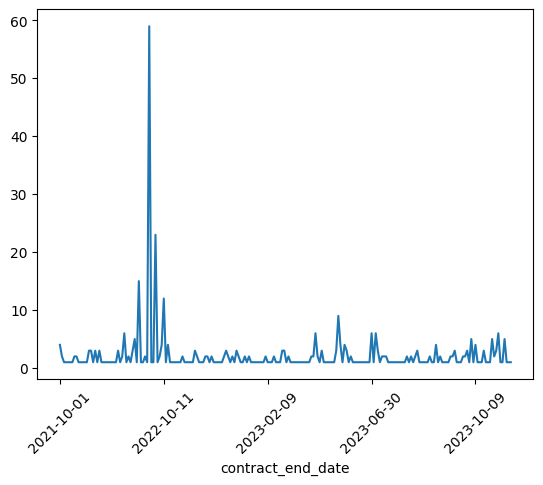

In [369]:
df_simple.groupby('contract_end_date')['status'].count().sort_index().rolling(1).sum().plot(rot=45)

### Mudando a coluna de data de começo de contrato para formato de data do pandas

In [370]:
df_simple['contract_start_date'] = pd.to_datetime(df_simple['contract_start_date'])
df_simple = df_simple.sort_values(by=['contract_start_date'])

In [371]:
df_simple['status'].value_counts()

won     574
lost    471
Name: status, dtype: int64

In [372]:
# #Dado um intervalo de tempo, criar analises de churn baseado na saúde da empresa
# #Criar um modelo de previsão de churn
# # saintes, entrantes, médias de pagamentos, std.pagamentos. Qde Total de Tentativas de Cobrança, Qde Total de Faturas

# df_filtered = df_simple[df_simple['contract_start_date'].between('2021-01-01', '2021-12-31')]
# df_filtered

# #novo dataframe com as colunas que serão usadas no modelo

# new_df = pd.DataFrame(columns=['saintes', 'entrantes', 'media_pagamentos', 'std_pagamentos', 'qde_total_tentativas_cobranca', 'qde_total_faturas', 'churn'])

# #atribuir valores ao novo dataframe

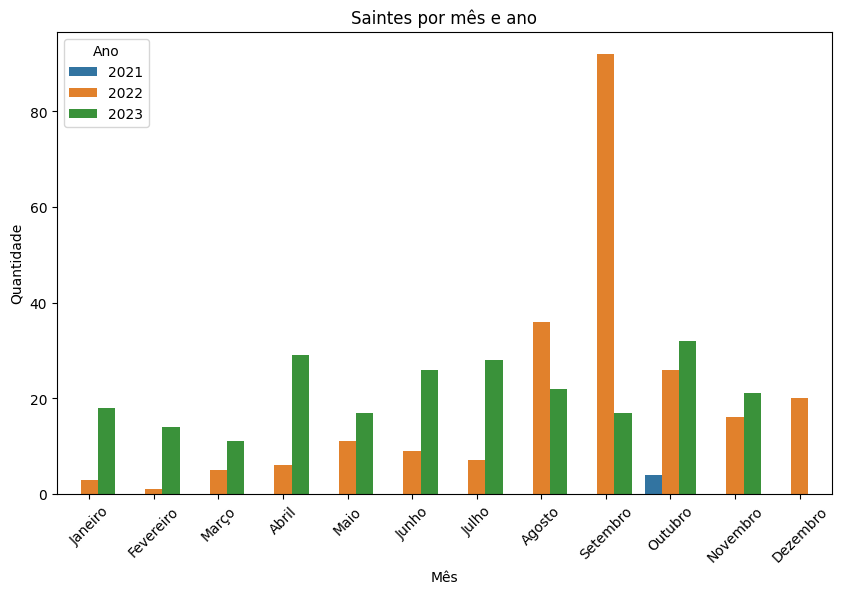

In [373]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd  # Make sure to import pandas if not already done

# Assuming df_simple is your DataFrame

# Convert 'contract_end_date' to datetime if not already in that format
df_simple['contract_end_date'] = pd.to_datetime(df_simple['contract_end_date'])

nome_dos_meses = ['Janeiro', 'Fevereiro', 'Março', 'Abril', 'Maio', 'Junho', 'Julho', 'Agosto', 'Setembro', 'Outubro', 'Novembro', 'Dezembro']

coluna = 'contract_end_date'
new_name = coluna + '_year'
df_simple[new_name] = df_simple[coluna].dt.year

# Plotar gráfico de barras separado por ano
plt.figure(figsize=(10, 6))  # Definir tamanho da figura
# Usar seaborn para criar facetas
sns.countplot(x=df_simple[coluna].dt.month, hue=df_simple[new_name])
plt.title('Saintes por mês e ano')  # <- Fix the line ending
# Rotacionar labels do eixo x
plt.xticks(rotation=45)
# Alterar labels do eixo x
plt.xticks(np.arange(12), nome_dos_meses)
# Trocar legenda da coluna
plt.legend(title='Ano', loc='upper left', labels=['2021', '2022', '2023'])
# Trocar nome do eixo x
plt.xlabel('Mês')
# Trocar nome do eixo y
plt.ylabel('Quantidade')
plt.show()


In [374]:
colunas_de_data = ['contract_end_date']

# LEmbrar de colocar a 'contract_end_date' para time delta posteriormente

#Trocar a data pelo tempo em dias ate o dia de hoje
for coluna in colunas_de_data:
    df[coluna] = pd.to_datetime(df[coluna], errors='coerce')
    df[coluna] = df[coluna].apply(lambda x: (datetime.now() - x).days)




In [375]:
def ultima_mensagem(x,y):
    if (y == None):
        return "Cliente"
    
    if x>y:
        return "Cliente"
    
    else:
        return "Empresa"

In [376]:
df_aux = df_simple[df_simple['Data Última Mensagens Inbound'].notnull()]
df_aux['Data Última Mensagens Inbound'] = pd.to_datetime(df_aux['Data Última Mensagens Inbound'])
df_aux['Data Última Mensagens Outbound'] = pd.to_datetime(df_aux['Data Última Mensagens Outbound'])
df_aux['Tempo Última Mensagem Inbound'] = df_aux['Data Última Mensagens Inbound'].apply(lambda x: (datetime.now() - x).days)
df_aux['Tempo Última Mensagem Outbound'] = df_aux['Data Última Mensagens Outbound'].apply(lambda x: (datetime.now() - x).days)

df_aux['Quem Enviou Última Mensagem'] = df_aux.apply(lambda row: ultima_mensagem(row['Tempo Última Mensagem Inbound'], row['Tempo Última Mensagem Outbound']), axis=1)


C:\Users\code\AppData\Local\Temp\ipykernel_20212\4269974155.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aux['Data Última Mensagens Inbound'] = pd.to_datetime(df_aux['Data Última Mensagens Inbound'])
C:\Users\code\AppData\Local\Temp\ipykernel_20212\4269974155.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aux['Data Última Mensagens Outbound'] = pd.to_datetime(df_aux['Data Última Mensagens Outbound'])
C:\Users\code\AppData\Local\Temp\ipykernel_20212\4269974155.py:4: SettingWithCopyWarning: 

In [377]:
df_aux['Quem Enviou Última Mensagem'].value_counts()
df_aux['Status Assinatura'] = df_aux['status'].apply(lambda x: "Ativa" if x == "won" else "Inativa")


C:\Users\code\AppData\Local\Temp\ipykernel_20212\3194983688.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aux['Status Assinatura'] = df_aux['status'].apply(lambda x: "Ativa" if x == "won" else "Inativa")


<AxesSubplot:title={'center':'Status dos Usuários em Relação a Última Mensagema'}, xlabel='Status Assinatura', ylabel='Quantidade Usuários'>

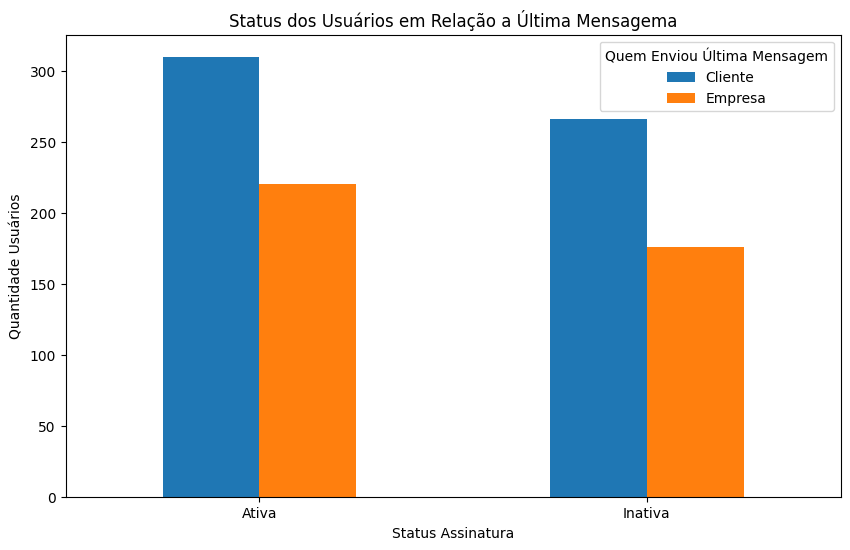

In [378]:
df_aux.groupby('Status Assinatura')['Quem Enviou Última Mensagem'].value_counts().unstack().plot(kind='bar', rot=0, ylabel='Quantidade Usuários', title='Status dos Usuários em Relação a Última Mensagema', figsize=(10,6))


<AxesSubplot:title={'center':'Quem enviou a última mensagem X Status do Cliente'}, xlabel='Status da Assinatura do Cliente', ylabel='Quantidade de Conversas'>

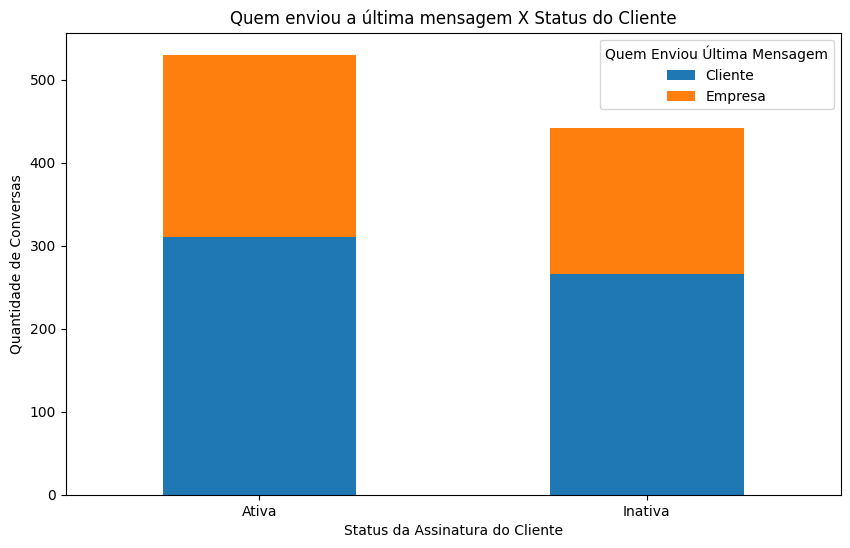

In [379]:
df_aux.groupby('Status Assinatura')['Quem Enviou Última Mensagem'].value_counts().unstack().plot(kind='bar', rot=0, ylabel='Quantidade de Conversas', xlabel="Status da Assinatura do Cliente", title='Quem enviou a última mensagem X Status do Cliente', stacked=True, figsize=(10,6))


<AxesSubplot:title={'center':'Quem enviou a última mensagem X Status do Cliente'}, xlabel='Status da Assinatura do Cliente', ylabel='Quantidade de Conversas'>

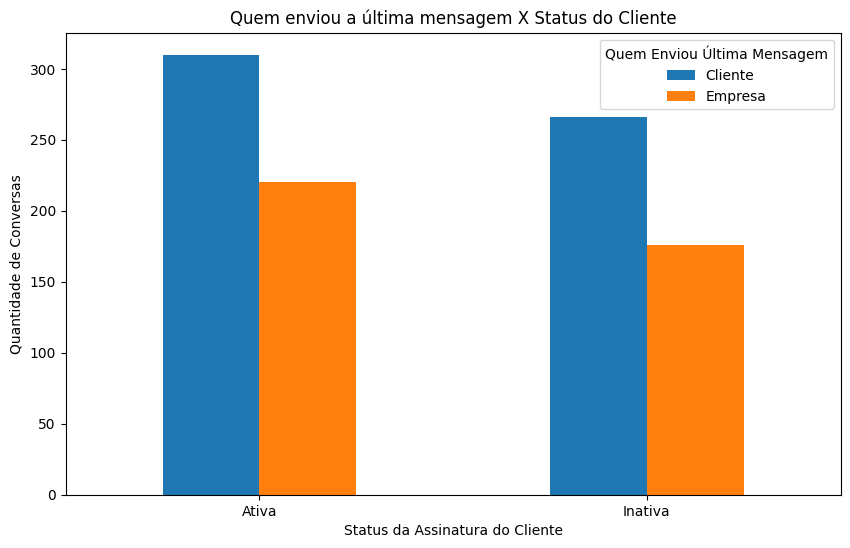

In [380]:
df_aux.groupby('Status Assinatura')['Quem Enviou Última Mensagem'].value_counts().unstack().plot(kind='bar', rot=0, ylabel='Quantidade de Conversas', xlabel="Status da Assinatura do Cliente", title='Quem enviou a última mensagem X Status do Cliente', figsize=(10,6))
